<div style="background-color: white; width: fit-content; padding: 10px;">
    <img src="https://i.postimg.cc/YSKMzPNY/PNG.png" width="200">
</div>

---

# **ETL pipeline for Climate analyses**

---

# 1. Initial configuration

## 1.1. Packages

In [1]:
# Standard library imports
import os
import sys
import math
import time
import re
import warnings
from datetime import datetime, timedelta
from glob import glob
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

# Third-party numerical/scientific imports
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.spatial.ckdtree import cKDTree
from scipy.interpolate import griddata

# GIS/Geospatial imports
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_origin
from rasterstats import zonal_stats

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Earth Engine imports
import ee
import json

# Utility/Progress imports
from tqdm import tqdm

# Weather data imports
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Suppress UserWarnings for centroid calculations
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_2956\3567366954.py:17: DeprecationWarning: Please import `cKDTree` from the `scipy.spatial` namespace; the `scipy.spatial.ckdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.ckdtree import cKDTree


### 1.2. Working drive

In [2]:
drive_letter = 'C'
drive_letter = 'D'

working_drive = 'C:'
working_drive = 'D:'

### 1.3. GEE authentication

In [3]:
ee.Authenticate() # in the script description you can find a guide of how to use GEE
ee.Initialize(project="ee-gis-jamirpradojunior") # Add your project from GEE

# 2. Era5Land dataset

Project link:

https://cds.climate.copernicus.eu/cdsapp#!/home

Monthly Aggregates: Google and Copernicus Climate Data Store (GEE collection)

https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR

## 2.1. Define AOI

In [4]:
# === 1. LOAD CENTROIDS ===
bbox_name = "Triangulo_e_Noroeste_Paulista"
centroids_path = f"{drive_letter}:/@Data_Lake/@Grid_shapefiles/centroid_grid_010km_{bbox_name}_WGS84.shp"
aoi_centroids_gdf = gpd.read_file(centroids_path)

# Ensure lon/lat columns
if 'lon' not in aoi_centroids_gdf.columns or 'lat' not in aoi_centroids_gdf.columns:
    aoi_centroids_gdf['lon'] = aoi_centroids_gdf.geometry.x
    aoi_centroids_gdf['lat'] = aoi_centroids_gdf.geometry.y

# Ensure ID column
if 'grid_id' in aoi_centroids_gdf.columns:
    id_col = 'grid_id'
elif 'FID' in aoi_centroids_gdf.columns:
    id_col = 'FID'
else:
    id_col = 'centroid_id'
    aoi_centroids_gdf[id_col] = [f"pt_{i}" for i in range(len(aoi_centroids_gdf))]

aoi_centroids_gdf['lon'] = aoi_centroids_gdf.geometry.x
aoi_centroids_gdf['lat'] = aoi_centroids_gdf.geometry.y

## 2.2. Extraction to Local Storage (No Existing Data Check)

In [5]:
# === Define Variables ===
ls_era5_variables = [
    'dewpoint_temperature_2m', 'temperature_2m', 'temperature_2m_min', 'temperature_2m_max',
    'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4',
    'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
    'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
    'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum',
    'evaporation_from_bare_soil_sum', 'evaporation_from_the_top_of_canopy_sum',
    'evaporation_from_vegetation_transpiration_sum', 'potential_evaporation_sum', 'total_evaporation_sum',
    'runoff_sum', 'sub_surface_runoff_sum', 'surface_runoff_sum',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'total_precipitation_sum', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'
]

In [6]:
# === ERA5-Land Direct Extraction  ===

# === 1. CONFIGURATION ===
start_str = '2025-01-01'
end_str = '2025-06-30'
output_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data"
os.makedirs(output_folder, exist_ok=True)
date_tag = f"{start_str.replace('-', '')}_{end_str.replace('-', '')}"
output_file = os.path.join(output_folder, f"raw_era5_data_{date_tag}.parquet")
error_log_file = os.path.join(output_folder, f"failed_chunks_era5_{date_tag}.csv")

# === 2. DATE RANGE AND INPUT ===
date_list = pd.date_range(start=start_str, end=end_str).strftime('%Y-%m-%d').tolist()

# Assumed preloaded: aoi_centroids_gdf and id_col
coord_lookup = {
    row[id_col]: (row['lon'], row['lat']) for _, row in aoi_centroids_gdf.iterrows()
}

# === 3. Group by date ===
grouped_by_day = defaultdict(set)
for date in date_list:
    grouped_by_day[date] = set(aoi_centroids_gdf[id_col])

# === 4. EE Helper ===
def get_fc_from_chunk(chunk_df):
    return ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point(row['lon'], row['lat']), {id_col: row[id_col]})
        for _, row in chunk_df.iterrows()
    ])

# === 5. Chunk processor with retries ===
def extract_day_chunk(task, max_retries=2):
    date_str, chunk_fids = task
    results = []

    for attempt in range(max_retries + 1):
        try:
            if not ee.data._credentials:
                ee.Initialize()

            img = (
                ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
                .filterDate(date_str, pd.to_datetime(date_str) + pd.Timedelta(days=1))
                .select(ls_era5_variables)
                .first()
            )

            if img is None:
                return []

            chunk_df = aoi_centroids_gdf[aoi_centroids_gdf[id_col].isin(chunk_fids)]
            fc_chunk = get_fc_from_chunk(chunk_df)

            samples = img.sampleRegions(
                collection=fc_chunk,
                scale=10000,
                geometries=False,
                tileScale=16
            )

            features = samples.getInfo().get('features', [])
            for feat in features:
                props = feat.get('properties', {})
                fid = props.get(id_col)
                lon, lat = coord_lookup.get(fid, (None, None))
                for var in ls_era5_variables:
                    if var in props:
                        results.append({
                            'FID': fid,
                            'longitude': lon,
                            'latitude': lat,
                            'date': date_str,
                            'variable': var,
                            'value': props[var]
                        })
            break  # Success

        except Exception as e:
            print(f"[ERROR] {date_str} | chunk failed (attempt {attempt+1}): {str(e)}")
            if attempt < max_retries:
                time.sleep(3)
            else:
                return {'date': date_str, 'fids': chunk_fids}

    return results

# === 6. Prepare Tasks ===
chunk_size = 1000
tasks = []
for date, fids in grouped_by_day.items():
    for i in range(0, len(fids), chunk_size):
        tasks.append((date, list(fids)[i:i + chunk_size]))

# === 7. Execute in Parallel ===
all_new_results = []
failed_chunks = []

with ThreadPoolExecutor(max_workers=6) as executor:
    futures = [executor.submit(extract_day_chunk, task) for task in tasks]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading ERA5 data"):
        result = future.result()
        if isinstance(result, dict) and 'date' in result:
            failed_chunks.append(result)
        else:
            all_new_results.extend(result)

# === 8. Save Outputs ===
if all_new_results:
    df = pd.DataFrame(all_new_results)
    df.to_parquet(output_file, index=False, compression='snappy')
    print(f"\n✅ Saved {len(df)} rows to {output_file}")
else:
    print("\n✅ No data extracted.")

# === 9. Save Error Log ===
if failed_chunks:
    pd.DataFrame(failed_chunks).to_csv(error_log_file, index=False)
    print(f"\n⚠️ Logged {len(failed_chunks)} failed chunks to: {error_log_file}")
else:
    print("\n✅ No failed chunks.")


✅ Saved 33399387 rows to D:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\raw_era5_data_20250101_20250630.parquet

✅ No failed chunks.


## 2.2. Dataset Overview & Quality Check

In [ ]:
# === Define Variables ===
ls_era5_variables = [
    'dewpoint_temperature_2m', 'temperature_2m', 'temperature_2m_min', 'temperature_2m_max',
    'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4',
    'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
    'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
    'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum',
    'evaporation_from_bare_soil_sum', 'evaporation_from_the_top_of_canopy_sum',
    'evaporation_from_vegetation_transpiration_sum', 'potential_evaporation_sum', 'total_evaporation_sum',
    'runoff_sum', 'sub_surface_runoff_sum', 'surface_runoff_sum',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'total_precipitation_sum', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'
]

# === 1. Load and Merge All ERA5-Land Raw Data Files ===

era5_land_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land"
raw_data_path = f"{era5_land_folder}/Raw_data"

# Get all ERA5 .parquet files
parquet_files = sorted([
    os.path.join(raw_data_path, f)
    for f in os.listdir(raw_data_path)
    if f.endswith(".parquet") and f.startswith("raw_era5_data_")
])

print(f"[INFO] Found {len(parquet_files)} ERA5 files.")

# Load centroids
all_fids = set(aoi_centroids_gdf[id_col])

[INFO] Found 26 ERA5 files.


In [10]:
# Prepare accumulators
date_min = None
date_max = None
covered_fids = set()
fid_date_counts = {}

# Stream each file one at a time
for path in parquet_files[0:4]:
    print(f"[INFO] Processing file: {os.path.basename(path)}")
    df = pd.read_parquet(path)

    # Update date range
    this_min = df['date'].min()
    this_max = df['date'].max()
    date_min = this_min if date_min is None else min(date_min, this_min)
    date_max = this_max if date_max is None else max(date_max, this_max)

    # Update FID coverage
    file_fids = df['FID'].unique()
    covered_fids.update(file_fids)

    # Count dates per FID
    for fid, count in df.groupby('FID')['date'].nunique().items():
        fid_date_counts[fid] = fid_date_counts.get(fid, 0) + count

# Create summary DataFrame
pivot_dates_per_fid = pd.DataFrame.from_dict(fid_date_counts, orient='index', columns=['n_dates']).reset_index()
pivot_dates_per_fid.rename(columns={'index': 'FID'}, inplace=True)
pivot_dates_per_fid.sort_values('n_dates', ascending=False, inplace=True)

[INFO] Processing file: raw_era5_data_20000101_20001231.parquet
[INFO] Processing file: raw_era5_data_20010101_20011231.parquet
[INFO] Processing file: raw_era5_data_20020101_20021231.parquet
[INFO] Processing file: raw_era5_data_20030101_20031231.parquet


In [13]:
# Missing FIDs
missing_fids = sorted(all_fids - covered_fids)

print("\n=== ERA5-Land Raw Data Summary ===")
print(f"Start date: {date_min}")
print(f"End date:   {date_max}")
print(f"Total FIDs in centroids: {len(all_fids)}")
print(f"Total covered FIDs:      {len(covered_fids)}")
print(f"Total missing FIDs:      {len(missing_fids)}")

# Export missing if needed
missing_gdf = aoi_centroids_gdf[aoi_centroids_gdf[id_col].isin(missing_fids)]
missing_gdf.to_file(f"{era5_land_folder}/missing_fids.shp")


=== ERA5-Land Raw Data Summary ===
Start date: 2000-01-01
End date:   2003-12-31
Total FIDs in centroids: 6386
Total covered FIDs:      6363
Total missing FIDs:      23


In [ ]:
# === 4. Check FID Coverage ===
# id_col = "FID"
all_fids = set(aoi_centroids_gdf[id_col])
covered_fids = set(merged_ERA5_data['FID'].unique())
missing_fids = sorted(all_fids - covered_fids)

print(f"[INFO] Total FIDs in centroids: {len(all_fids)}")
print(f"[INFO] Total FIDs covered in ERA5 data: {len(covered_fids)}")
print(f"[INFO] Total missing FIDs: {len(missing_fids)}")

# === 5. Export Missing FIDs (optional) ===
missing_gdf = aoi_centroids_gdf[aoi_centroids_gdf[id_col].isin(missing_fids)]
#missing_gdf.to_file(f"{era5_land_folder}/missing_fids.shp")

## 2.4. Download data for the current year

In [ ]:
# === CONFIGURATION ===
output_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data"
os.makedirs(output_folder, exist_ok=True)

current_year = 2025
id_col = "FID"

# === Initialize Earth Engine ===
ee.Initialize()

# === Get Latest Available Date from ERA5-Land ===
latest_img = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").sort('system:time_start', False).first()
latest_date = ee.Date(latest_img.get('system:time_start')).format('YYYY-MM-dd').getInfo()

# === Check for Existing File for This Year ===
existing_raw_file = sorted(glob(os.path.join(output_folder, f"raw_era5_data_{current_year}0101_*.parquet")))
existing_df = None
if existing_raw_file:
    existing_file = existing_raw_file[-1]
    print(f"[INFO] Found existing file: {os.path.basename(existing_file)}")
    existing_df = pd.read_parquet(existing_file)

    if not existing_df.empty:
        latest_downloaded_date = pd.to_datetime(existing_df['date'].max())
        print(f"[INFO] Last downloaded date: {latest_downloaded_date.date()}")
    else:
        latest_downloaded_date = pd.to_datetime(f"{current_year}-01-01") - pd.Timedelta(days=1)
else:
    latest_downloaded_date = pd.to_datetime(f"{current_year}-01-01") - pd.Timedelta(days=1)

# === Define Date Range to Update ===
start_dt = latest_downloaded_date + pd.Timedelta(days=1)
end_dt = pd.to_datetime(latest_date)

if start_dt > end_dt:
    print("[INFO] No new data to download. Already up to date.")
    exit()

# === Update File Paths ===
start_str = start_dt.strftime('%Y-%m-%d')
end_str = end_dt.strftime('%Y-%m-%d')
date_tag = f"{start_str.replace('-', '')}_{end_str.replace('-', '')}"
output_file = os.path.join(output_folder, f"raw_era5_data_{date_tag}.parquet")
error_log_file = os.path.join(output_folder, f"failed_chunks_era5_{date_tag}.csv")



# === Date List to Process ===
date_list = pd.date_range(start=start_str, end=end_str).strftime('%Y-%m-%d').tolist()

# Assumed preloaded: aoi_centroids_gdf and id_col
coord_lookup = {
    row[id_col]: (row['lon'], row['lat']) for _, row in aoi_centroids_gdf.iterrows()
}

# === 3. Group by date ===
grouped_by_day = defaultdict(set)
for date in date_list:
    grouped_by_day[date] = set(aoi_centroids_gdf[id_col])

# === 4. EE Helper ===
def get_fc_from_chunk(chunk_df):
    return ee.FeatureCollection([
        ee.Feature(ee.Geometry.Point(row['lon'], row['lat']), {id_col: row[id_col]})
        for _, row in chunk_df.iterrows()
    ])

# === 5. Chunk processor with retries ===
def extract_day_chunk(task, max_retries=2):
    date_str, chunk_fids = task
    results = []

    for attempt in range(max_retries + 1):
        try:
            if not ee.data._credentials:
                ee.Initialize()

            img = (
                ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
                .filterDate(date_str, pd.to_datetime(date_str) + pd.Timedelta(days=1))
                .select(ls_era5_variables)
                .first()
            )

            if img is None:
                return []

            chunk_df = aoi_centroids_gdf[aoi_centroids_gdf[id_col].isin(chunk_fids)]
            fc_chunk = get_fc_from_chunk(chunk_df)

            samples = img.sampleRegions(
                collection=fc_chunk,
                scale=10000,
                geometries=False,
                tileScale=8
            )

            features = samples.getInfo().get('features', [])
            for feat in features:
                props = feat.get('properties', {})
                fid = props.get(id_col)
                lon, lat = coord_lookup.get(fid, (None, None))
                for var in ls_era5_variables:
                    if var in props:
                        results.append({
                            'FID': fid,
                            'longitude': lon,
                            'latitude': lat,
                            'date': date_str,
                            'variable': var,
                            'value': props[var]
                        })
            break  # Success

        except Exception as e:
            print(f"[ERROR] {date_str} | chunk failed (attempt {attempt+1}): {str(e)}")
            if attempt < max_retries:
                time.sleep(3)
            else:
                return {'date': date_str, 'fids': chunk_fids}

    return results

# === 6. Prepare Tasks ===
chunk_size = 500
tasks = []
for date, fids in grouped_by_day.items():
    for i in range(0, len(fids), chunk_size):
        tasks.append((date, list(fids)[i:i + chunk_size]))

# === 7. Execute in Parallel ===
all_new_results = []
failed_chunks = []

with ThreadPoolExecutor(max_workers=6) as executor:
    futures = [executor.submit(extract_day_chunk, task) for task in tasks]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading ERA5 data"):
        result = future.result()
        if isinstance(result, dict) and 'date' in result:
            failed_chunks.append(result)
        else:
            all_new_results.extend(result)

# === 8. Save Outputs ===
if all_new_results:
    df = pd.DataFrame(all_new_results)
    df.to_parquet(output_file, index=False, compression='snappy')
    print(f"\n✅ Saved {len(df)} rows to {output_file}")
else:
    print("\n✅ No data extracted.")

# === 9. Save Error Log ===
if failed_chunks:
    pd.DataFrame(failed_chunks).to_csv(error_log_file, index=False)
    print(f"\n⚠️ Logged {len(failed_chunks)} failed chunks to: {error_log_file}")
else:
    print("\n✅ No failed chunks.")


## 2.4. Merge ERA5-Land Raw Parquet Files

In [17]:
# === 1. Define raw file folder and list all ERA5 .parquet files ===
raw_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data"
raw_files = sorted(glob(os.path.join(raw_folder, "raw_era5_data_*.parquet")))
raw_files

['C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20000101_20001231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20010101_20011231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20020101_20021231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20030101_20031231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20040101_20041231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20050101_20051231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20060101_20061231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20070101_20071231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20080101_20081231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data\\raw_era5_data_20090101_20091231.parquet',
 'C:/@Data_Lake/climate_data_lake/ERA5_L

In [ ]:
# === 1. Define raw file folder and list all ERA5 .parquet files ===
raw_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data"
raw_files = sorted(glob(os.path.join(raw_folder, "raw_era5_data_*.parquet")))

print(f"[INFO] Found {len(raw_files)} raw files to merge.")

# === 2. Load and concatenate all raw files ===
df_list = [pd.read_parquet(fp) for fp in raw_files]
merged_ERA5_data = pd.concat(df_list, ignore_index=True)

# === 3. Clean: remove duplicates, sort data, reset index ===
merged_ERA5_data.drop_duplicates(subset=["FID", "variable", "date"], inplace=True)
merged_ERA5_data.sort_values(by=["FID", "variable", "date"], inplace=True)
merged_ERA5_data.reset_index(drop=True, inplace=True)

# === 4. Extract date range to use in filename ===
start_date_str = pd.to_datetime(merged_ERA5_data['date'].min()).strftime('%Y%m%d')
end_date_str   = pd.to_datetime(merged_ERA5_data['date'].max()).strftime('%Y%m%d')
merged_filename = f"merged_raw_era5_data_{start_date_str}_{end_date_str}.parquet"
merged_output_path = os.path.join(raw_folder, merged_filename)

# === 5. Save the final merged file ===
merged_ERA5_data.to_parquet(merged_output_path, index=False, compression='snappy')
print(f"\n✅ Merged dataset saved to:\n{merged_output_path}")

# === 6. Dataset Summary ===
print("\n[INFO] ERA5-Land Dataset Summary:")
print("Start date:", merged_ERA5_data['date'].min())
print("End date:  ", merged_ERA5_data['date'].max())
print("Total rows:", len(merged_ERA5_data))
print("Unique FIDs:", merged_ERA5_data['FID'].nunique())

## 2.5. Load raw data, transform and export

In [ ]:
# === 1. Load ERA5-Land Raw Data ===
raw_data_path = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Raw_data/merged_raw_era5_data_{start_date_str}_{end_date_str}.parquet"
merged_ERA5_data = pd.read_parquet(raw_data_path)

# === 2. Define variable groups based on transformations and units ===

# Convert Kelvin to Celsius
ls_var_kelvin_transf = [
    'dewpoint_temperature_2m', 'temperature_2m', 'temperature_2m_min', 'temperature_2m_max',
    'soil_temperature_level_1', 'soil_temperature_level_2',
    'soil_temperature_level_3', 'soil_temperature_level_4'
]

# Convert meters to millimeters
ls_var_m_to_mm_transf = [
    'evaporation_from_bare_soil_sum', 'evaporation_from_the_top_of_canopy_sum',
    'evaporation_from_vegetation_transpiration_sum', 'potential_evaporation_sum',
    'total_evaporation_sum', 'runoff_sum', 'sub_surface_runoff_sum',
    'surface_runoff_sum', 'total_precipitation_sum'
]

# No transformation
ls_var_no_transf = [
    'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
    'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
    'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum',
    'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'
]

# === 3. Apply value transformations ===
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_var_kelvin_transf), 'value'] -= 273.15
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_var_m_to_mm_transf), 'value'] *= 1000

# === 4. Define unit categories ===
ls_volume_fraction = [
    'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4'
]

ls_area_fraction = [
    'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'
]

ls_irradiation = [
    'surface_net_solar_radiation_sum', 'surface_net_thermal_radiation_sum',
    'surface_solar_radiation_downwards_sum', 'surface_thermal_radiation_downwards_sum'
]

ls_wind = ['u_component_of_wind_10m', 'v_component_of_wind_10m']

# === 5. Assign units to each variable ===
merged_ERA5_data['unit'] = None  # Init column

merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_var_kelvin_transf), 'unit'] = '°C'
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_var_m_to_mm_transf), 'unit'] = 'mm'
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_volume_fraction), 'unit'] = 'volume_fraction'
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_area_fraction), 'unit'] = 'area_fraction'
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_irradiation), 'unit'] = 'J/m^2'
merged_ERA5_data.loc[merged_ERA5_data['variable'].isin(ls_wind), 'unit'] = 'm/s'

# === 6. Create variable__unit composite column ===
merged_ERA5_data['variable__unit'] = (
    merged_ERA5_data['variable'] + "__" + merged_ERA5_data['unit']
)

# === 7. Save to processed dataset ===
output_folder = f"{drive_letter}:/@Data_Lake/climate_data_lake/ERA5_Land/Processed_data"
os.makedirs(os.path.dirname(output_folder), exist_ok=True)
output_file = f"{output_folder}/transformed_era5_data_{start_str}_to_{end_str}.parquet"
merged_ERA5_data.to_parquet(output_file, index=False, compression='snappy')

# === 8. Preview ===
merged_ERA5_data

# 3. Open-meteo (Weather forescast)

https://open-meteo.com/en/docs

https://open-meteo.com/en/docs/historical-weather-api

## 3.1. Define AOI

In [9]:
# === Open-Meteo Daily Climate Data Downloader ===
import os
import pandas as pd
import requests_cache
from openmeteo_sdk import openmeteo_requests
from retry_requests import retry
from datetime import datetime

ImportError: cannot import name 'openmeteo_requests' from 'openmeteo_sdk' (c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\openmeteo_sdk\__init__.py)

In [ ]:
# === 1. LOAD CENTROIDS ===
bbox_name = "Triangulo_e_Noroeste_Paulista"
centroids_path = f"{drive_letter}:/@Data_Lake/Grid_shapefiles/centroid_grid_010km_{bbox_name}_WGS84.shp"
aoi_centroids_gdf = gpd.read_file(centroids_path)

# Ensure lon/lat columns
if 'lon' not in aoi_centroids_gdf.columns or 'lat' not in aoi_centroids_gdf.columns:
    aoi_centroids_gdf['lon'] = aoi_centroids_gdf.geometry.x
    aoi_centroids_gdf['lat'] = aoi_centroids_gdf.geometry.y

# Ensure ID column
if 'grid_id' in aoi_centroids_gdf.columns:
    id_col = 'grid_id'
elif 'FID' in aoi_centroids_gdf.columns:
    id_col = 'FID'
else:
    id_col = 'centroid_id'
    aoi_centroids_gdf[id_col] = [f"pt_{i}" for i in range(len(aoi_centroids_gdf))]

aoi_centroids_gdf['lon'] = aoi_centroids_gdf.geometry.x
aoi_centroids_gdf['lat'] = aoi_centroids_gdf.geometry.y

In [ ]:


# === CONFIGURATION ===
openmeteo_url = "https://api.open-meteo.com/v1/forecast"
output_climate_data_path = f"{output_climate_folder_path}/climate_openmeteo.parquet"

params_base = {
    "daily": [
        "temperature_2m_max", "temperature_2m_mean", "temperature_2m_min", "dew_point_2m_mean",
        "relative_humidity_2m_mean", "relative_humidity_2m_max", "relative_humidity_2m_min", "uv_index_max",
        "uv_index_clear_sky_max", "shortwave_radiation_sum", "wet_bulb_temperature_2m_mean",
        "wet_bulb_temperature_2m_max", "wet_bulb_temperature_2m_min", "vapour_pressure_deficit_max",
        "et0_fao_evapotranspiration", "wind_direction_10m_dominant", "wind_gusts_10m_max", "wind_speed_10m_max",
        "precipitation_probability_mean", "precipitation_probability_min", "leaf_wetness_probability_mean",
        "growing_degree_days_base_0_limit_50", "et0_fao_evapotranspiration_sum", "precipitation_sum",
        "precipitation_hours", "precipitation_probability_max", "rain_sum"
    ],
    "timezone": "America/Sao_Paulo",
    "past_days": 5,
    "forecast_days": 3
}

# === SETUP CACHED SESSION ===
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# === LOAD EXISTING DATA ===
if os.path.exists(output_climate_data_path):
    df_existing = pd.read_parquet(output_climate_data_path)
    print(f"[INFO] Loaded existing dataset with {len(df_existing)} records.")
else:
    df_existing = pd.DataFrame()

# === EXTRACT & DOWNLOAD MISSING DATA ===
all_data = []
limit_reached = False

for idx, row in aoi_centroids_gdf.iterrows():
    if limit_reached:
        break

    fid = row['FID']
    lat, lon = row['latitude'], row['longitude']
    print(f"[INFO] Processing FID {fid} ({lat}, {lon})")

    params = params_base.copy()
    params.update({"latitude": lat, "longitude": lon})

    try:
        responses = openmeteo.weather_api(openmeteo_url, params=params)
        response = responses[0]
        daily = response.Daily()

        new_dates = pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ).tz_convert(None)

        # Skip if data already exists for all dates
        existing_dates = set(df_existing[df_existing['FID'] == fid]['date'])
        missing_dates = [d for d in new_dates if d not in existing_dates]
        if not missing_dates:
            print(f"[SKIP] All dates already available for FID {fid}")
            continue

        # Assemble new data
        daily_data = {
            "date": new_dates,
            "latitude": lat,
            "longitude": lon,
            "FID": fid
        }

        for i, var in enumerate(params["daily"]):
            daily_data[var] = daily.Variables(i).ValuesAsNumpy()

        point_df = pd.DataFrame(daily_data)
        point_df = point_df[point_df['date'].isin(missing_dates)]
        all_data.append(point_df)

    except Exception as e:
        print(f"[ERROR] FID {fid}: {str(e)}")
        # Insert NaNs for all expected variables on the missing dates
        if 'daily_data' not in locals():
            daily_data = {
                "date": pd.date_range(datetime.today(), periods=8),  # 5 past + 3 forecast
                "latitude": lat,
                "longitude": lon,
                "FID": fid
            }
            for var in params["daily"]:
                daily_data[var] = [None] * 8
            all_data.append(pd.DataFrame(daily_data))

        limit_reached = True  # Stop further requests if quota reached
        break

# === MERGE AND SAVE ===
if all_data:
    df_new = pd.concat(all_data, ignore_index=True)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.drop_duplicates(subset=['FID', 'date'], inplace=True)
    df_combined.sort_values(by=['FID', 'date'], inplace=True)
    df_combined.to_parquet(output_climate_data_path, index=False, compression='snappy')
    print(f"[✅] Climate data updated: {output_climate_data_path}")
else:
    print("[✅] No new data downloaded.")

# 5. Post processing CLIMATE DATA

In [ ]:
# Export data
df_all_climate_results = pd.read_csv(f"{working_drive}/@Data_Lake/@Projects/Buffer_piloto_01/Datasets/transformed_era5_data_{start_date}_to_{end_date}.csv")
df_all_climate_results

,farm_sicar,variable,date,value,unit,variable__unit
0,MG-3170107-4DA46B4CC3BB4E52A50202E536619360,dewpoint_temperature_2m,2015-05-01,15.999543,°C,dewpoint_temperature_2m__°C
1,MG-3170107-4DA46B4CC3BB4E52A50202E536619360,temperature_2m,2015-05-01,20.141384,°C,temperature_2m__°C
2,MG-3170107-4DA46B4CC3BB4E52A50202E536619360,temperature_2m_min,2015-05-01,16.926736,°C,temperature_2m_min__°C
3,MG-3170107-4DA46B4CC3BB4E52A50202E536619360,temperature_2m_max,2015-05-01,23.929376,°C,temperature_2m_max__°C
4,MG-3170107-4DA46B4CC3BB4E52A50202E536619360,soil_temperature_level_1,2015-05-01,21.205647,°C,soil_temperature_level_1__°C
...,...,...,...,...,...,...
2944313,MG-3170107-5AFA2A9076D44A929A69835AF659FF9E,u_component_of_wind_10m,2024-12-08,0.034334,m/s,u_component_of_wind_10m__m/s
2944314,MG-3170107-5AFA2A9076D44A929A69835AF659FF9E,v_component_of_wind_10m,2024-12-08,-0.845523,m/s,v_component_of_wind_10m__m/s
2944315,MG-3170107-5AFA2A9076D44A929A69835AF659FF9E,total_precipitation_sum,2024-12-08,0.000000,mm,total_precipitation_sum__mm
2944316,MG-3170107-5AFA2A9076D44A929A69835AF659FF9E,leaf_area_index_high_vegetation,2024-12-08,1.983007,area_fraction,leaf_area_index_high_vegetation__area_fraction


C:\Users\Usuario\AppData\Local\Temp\ipykernel_9884\1751231357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_farm['date'] = pd.to_datetime(df_single_farm['date'])


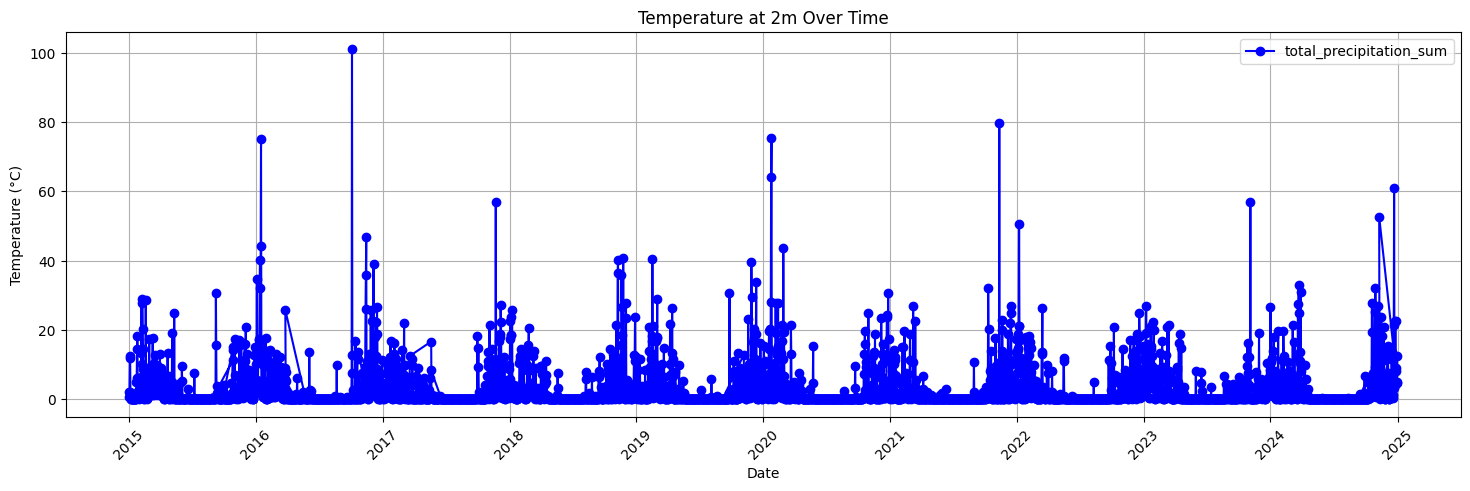

In [18]:
climate_var = 'total_precipitation_sum'

df_single_farm = df_all_climate_results[(df_all_climate_results.farm_sicar=='MG-3170107-4DA46B4CC3BB4E52A50202E536619360') & (df_all_climate_results.variable==climate_var)]

import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is in datetime format
df_single_farm['date'] = pd.to_datetime(df_single_farm['date'])

# Plot temperature vs. date
plt.figure(figsize=(18, 5))
plt.plot(df_single_farm['date'], df_single_farm['value'], marker='o', linestyle='-', color='b', label=f'{climate_var}')

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature at 2m Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.show()

In [ ]:
#df_all_climate_results = df_all_results_eraland5.copy()
#df_all_climate_results = pd.concat([df_all_results_eraland5, df_all_chirps_precipitation])
df_all_climate_results['year'] = df_all_climate_results.year_month.str[:4]
df_all_climate_results['month_num'] = df_all_climate_results.year_month.str[5:7]
df_all_climate_results['month'] = pd.to_datetime(df_all_climate_results['year_month'], format='%Y-%m').dt.strftime('%b')
df_all_climate_results['month_full'] = pd.to_datetime(df_all_climate_results['year_month'], format='%Y-%m').dt.strftime('%B')

df_all_climate_results_monthly = pd.pivot_table(df_all_climate_results, index=['roi_name', 'month_num'], columns='variable__unit', values='mean', aggfunc='mean')
df_all_climate_results_annual = pd.pivot_table(df_all_climate_results, index=['roi_name', 'year'], columns='variable__unit', values='mean', aggfunc='mean')

# List of columns to multiply 12
columns_to_multiply = ['precipitation_chirps__mm', 'total_evaporation_sum__mm', 'total_precipitation_sum__mm']
df_all_climate_results_annual[columns_to_multiply] = df_all_climate_results_annual[columns_to_multiply] * 12

df_all_climate_results_monthly.reset_index(inplace=True)
df_all_climate_results_annual.reset_index(inplace=True)
df_all_climate_results_monthly['water_balance__mm'] = df_all_climate_results_monthly['precipitation_chirps__mm'] + df_all_climate_results_monthly['total_evaporation_sum__mm']
df_all_climate_results_monthly.head()

In [ ]:
df_all_results_eraland5.to

In [ ]:
import numpy as np

def calculate_relative_humidity(T, Td):
    """Calculate relative humidity (%) from temperature (T) and dew point (Td).
    August-Roche-Magnus equation
    
    T  = Air temperature in °C
    Td = Dew point temperature in °C
    """
    e_T = 6.112 * np.exp((17.62 * T) / (243.12 + T))
    e_Td = 6.112 * np.exp((17.62 * Td) / (243.12 + Td))
    
    RH = (e_Td / e_T) * 100
    return RH

# Example: T = 30°C, Td = 20°C
T = 30  # Air temperature in °C
Td = 20  # Dew point in °C
RH = calculate_relative_humidity(T, Td)

print(f"Relative Humidity: {RH:.2f}%")


# 5. Generate rasters

In [ ]:
# Load climate data
climate_data = pd.read_csv(f"{working_drive}/@Agro_ID/Coopercitrus_Bebedouro/Climate_analyses/climate_data_openmeteo.csv")
climate_data